In [129]:
import zipfile
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import datetime
from dateutil import tz
os.chdir('/Users/a.kholodov/Documents/02. Personal/20. Education/50. Universities/Springboard/Springboard_git/Springboard _repo/CS2-flights-delay-REPO')

# pd.set_option('display.max_rows', 130)
# pd.set_option('display.width', 200)

# Loading timezones for IATA codes of airports
IATAtz_df = pd.read_csv('https://raw.githubusercontent.com/hroptatyr/dateutils/tzmaps/iata.tzmap', 
                        sep = '\t', 
                        index_col=0, 
                        header=None)

# Dictionary with IATA codes as keys and timezones as values
IATAtz = IATAtz_df.to_dict('dict')[1]
del(IATAtz_df)

In [130]:
data_types = {
    'FlightDate':           'str',
    'Flight_Number_Reporting_Airline':  np.int16,
    'Origin':               'category',
    'Dest':                 'category',
    'CRSDepTime':           np.int16,
    'DepTime':              np.float32,
    'DepDelay':             np.float32,
    'CRSArrTime':           np.int16,
    'ArrTime':              np.float32,
    'ArrDelay':             np.float32,
    'Cancelled':            np.int8,        # boolean
    'Diverted':             np.int8,        # boolean
    'CRSElapsedTime':       np.float32,
    'ActualElapsedTime':    np.float32,
    'AirTime':              np.float32}

In [131]:
def load_data_from(zip_file, data_file, field_type=None):
    '''
    zip_file - path and name of source zip-file contaning 60 csv files
    dat_faile - path and name of csv-file with data
    field_type - dictinary with fields to load and thiers relative data types
    '''
    # reading the file
    with zipfile.ZipFile(zip_file) as zip_source:
        with zip_source.open(data_file) as file:
            if field_type != None:
                df = pd.read_csv(file, header = 0, 
                                usecols = field_type.keys(),
                                dtype = field_type)
            else:
                df = pd.read_csv(file, header = 0, low_memory=False)

    # Converting dates and boolean        
    if 'FlightDate' in df.columns:
        df['FlightDate'] = pd.to_datetime(df['FlightDate'])
    if 'DivReachedDest' in df.columns:
        df['DivReachedDest'] = df['DivReachedDest'].fillna(0)
    if 'Cancelled' in df.columns:
        df['Cancelled'] = df['Cancelled'].astype('bool')
    if 'Diverted' in df.columns:
        df['Diverted'] = df['Diverted'].astype('bool')
    if 'DivReachedDest' in df.columns:
        df['DivReachedDest'] = df['DivReachedDest'].astype('bool')
    return df

In [132]:
# The most important combinations of fields for analysis
Date_details = ['FlightDate']
DepTime_details = ['CRSDepTime', 'DepTime']
ArrTime_details = ['CRSArrTime', 'ArrTime']
DepTime_min_details = ['CRSDepTime_min', 'DepTime_min']
ArrTime_min_details = ['CRSArrTime_min', 'ArrTime_min']
ElapsedTime_details = ['CRSElapsedTime', 'ActualElapsedTime']
CRS_details = ['CRSDepTime', 'CRSArrTime', 'CRSElapsedTime']
CRS_min_details = ['CRSDepTime_min', 'CRSArrTime_min', 'CRSElapsedTime']
Route_datails = ['Origin', 'Dest']

In [133]:
# Loading some dataset just for tests
source_zip = 'data/interim/csv_flight.zip'
source_path = 'csv_flight/report_'

flights = load_data_from(source_zip, source_path + '2014_3.csv', data_types)

In [134]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503758 entries, 0 to 503757
Data columns (total 15 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   FlightDate                       503758 non-null  datetime64[ns]
 1   Flight_Number_Reporting_Airline  503758 non-null  int16         
 2   Origin                           503758 non-null  category      
 3   Dest                             503758 non-null  category      
 4   CRSDepTime                       503758 non-null  int16         
 5   DepTime                          494193 non-null  float32       
 6   DepDelay                         494193 non-null  float32       
 7   CRSArrTime                       503758 non-null  int16         
 8   ArrTime                          493729 non-null  float32       
 9   ArrDelay                         493043 non-null  float32       
 10  Cancelled                        503758 non-

In [135]:
# Fuilter for all flights from SEA to JFK airport and back
SEA_JFK = (flights['Origin'] == 'SEA') & (flights['Dest'] == 'JFK')
JFK_SEA = (flights['Origin'] == 'JFK') & (flights['Dest'] == 'SEA')

In [136]:
print(flights[SEA_JFK][Date_details + CRS_details].head(10))

del(SEA_JFK)

      FlightDate  CRSDepTime  CRSArrTime  CRSElapsedTime
49479 2014-03-01         715        1529           314.0
49480 2014-03-02         715        1529           314.0
49481 2014-03-03         715        1529           314.0
49482 2014-03-04         715        1529           314.0
49483 2014-03-05         715        1529           314.0
49484 2014-03-06         715        1540           325.0
49485 2014-03-07         715        1540           325.0
49486 2014-03-08         715        1540           325.0
49487 2014-03-09         715        1540           325.0
49488 2014-03-10         715        1540           325.0


In [137]:
print(flights[JFK_SEA][Date_details + CRS_details].head(10))

del(JFK_SEA)

      FlightDate  CRSDepTime  CRSArrTime  CRSElapsedTime
49448 2014-03-01        1845        2215           390.0
49449 2014-03-02        1845        2215           390.0
49450 2014-03-03        1845        2215           390.0
49451 2014-03-04        1845        2215           390.0
49452 2014-03-05        1845        2215           390.0
49453 2014-03-06        1800        2115           375.0
49454 2014-03-07        1800        2115           375.0
49455 2014-03-08        1800        2115           375.0
49456 2014-03-09        1800        2115           375.0
49457 2014-03-10        1800        2115           375.0


In [138]:
# Filter for flights when CRS Arrival time is less of equal than CRS Departure time
CRSArrTime_less_than_CRSDepTime = flights['CRSArrTime'] <= flights['CRSDepTime']

# Filter for flights lasting less than 60 minutes (CRS)
less_than_60_min = flights['CRSElapsedTime'] < 60

# Flights where CRS Arrival time less than CRS Departure time AND a flight was less than 60 min
# To evaluate is it possible to 'travel in time' - to arrive the same day earlier 
print(flights[CRSArrTime_less_than_CRSDepTime & less_than_60_min][Date_details + CRS_details] \
    .sort_values('CRSElapsedTime').head())

del(CRSArrTime_less_than_CRSDepTime)

       FlightDate  CRSDepTime  CRSArrTime  CRSElapsedTime
342964 2014-03-08        2350          29            39.0
342963 2014-03-07        2350          29            39.0
342961 2014-03-06        2350          29            39.0
211861 2014-03-01        1815        1801            46.0
319613 2014-03-28        1243        1230            47.0


### Examining the CRS Elapsed time

In [139]:
# [TRANSFORMATION]
# # Convert Arrival and Departure times (CRS and Actual) to minutes
flights['CRSArrTime_min'] = flights['CRSArrTime'] // 100 * 60 + flights['CRSArrTime'] % 100
flights['CRSDepTime_min'] = flights['CRSDepTime'] // 100 * 60 + flights['CRSDepTime'] % 100
flights['ArrTime_min'] = flights['ArrTime'] // 100 * 60 + flights['ArrTime'] % 100
flights['DepTime_min'] = flights['DepTime'] // 100 * 60 + flights['DepTime'] % 100

In [140]:
# Filter for flights when CRS Arrival time is less of equal than CRS Departure time
CRSArr_less_than_CRSDep_min = flights['CRSArrTime_min'] <= flights['CRSDepTime_min']

# FOR TIMES EXPRESSED IN MINUTES !!!
# Flights where CRS Arrival time less than CRS Departure time AND a flight was less than 60 min
# To evaluate is it possible to 'travel in time' - to arrive the same day earlier 
flights[CRSArr_less_than_CRSDep_min & less_than_60_min][Date_details + CRS_min_details] \
    .sort_values('CRSElapsedTime').head()

,FlightDate,CRSDepTime_min,CRSArrTime_min,CRSElapsedTime
342964,2014-03-08,1430,29,39.0
342963,2014-03-07,1430,29,39.0
342961,2014-03-06,1430,29,39.0
211861,2014-03-01,1095,1081,46.0
319613,2014-03-28,763,750,47.0


In [141]:
# ... and the END of the table
flights[CRSArr_less_than_CRSDep_min & less_than_60_min][Date_details + CRS_min_details] \
    .sort_values('CRSElapsedTime').tail()

,FlightDate,CRSDepTime_min,CRSArrTime_min,CRSElapsedTime
306171,2014-03-16,965,964,59.0
306170,2014-03-24,965,964,59.0
306169,2014-03-23,965,964,59.0
306176,2014-03-21,965,964,59.0
392396,2014-03-01,1115,1114,59.0


In [142]:
# [TRANSFORMATION]
# Calculation of the difference between departure and arrival time 
flights['CRS_Arr_minus_Dep'] = flights['CRSArrTime_min'] - flights['CRSDepTime_min'] 

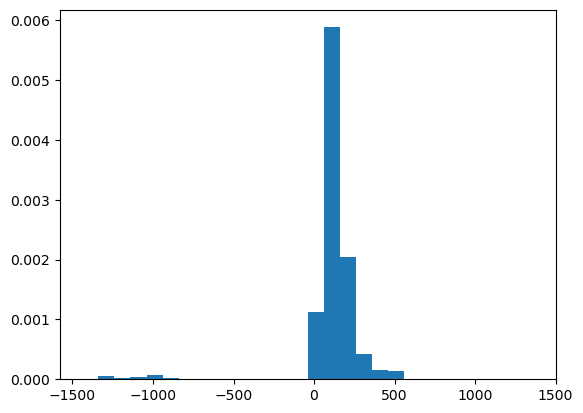

In [143]:
# Examine the difference between CRS Arrival and Departure times
bins = np.arange(-1440, 1440, 100)
plt.hist(flights['CRS_Arr_minus_Dep'], density=True,  bins = bins)
plt.show()

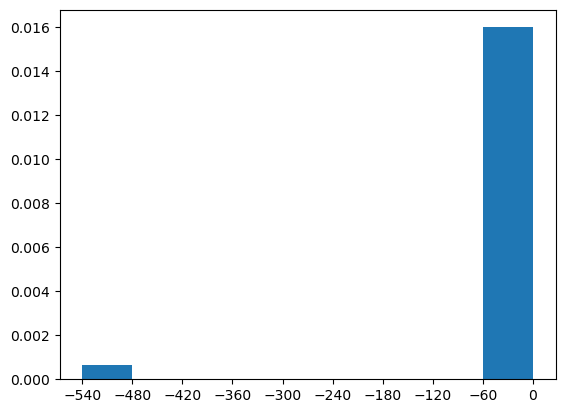

In [144]:
# Examine MORE CLOSELY the difference between CRS Arrival and Departure times 
bins = np.arange(-540, 60, 60)
plt.hist(flights['CRS_Arr_minus_Dep'], density=True,  bins = bins)
plt.xticks(bins)
plt.show()

In [145]:
# Examine the difference between CRS Arrival and Departure times
flights['CRS_Arr_minus_Dep'].describe()

count    503758.000000
mean        103.795247
std         203.069015
min       -1419.000000
25%          75.000000
50%         108.000000
75%         165.000000
max         675.000000
Name: CRS_Arr_minus_Dep, dtype: float64

In [146]:
# Are there any values between -900 and -200
diff_between_900_200 = (flights['CRS_Arr_minus_Dep'] > -480) & (flights['CRS_Arr_minus_Dep'] < -60)
print(flights[diff_between_900_200])

del(diff_between_900_200)

Empty DataFrame
Columns: [FlightDate, Flight_Number_Reporting_Airline, Origin, Dest, CRSDepTime, DepTime, DepDelay, CRSArrTime, ArrTime, ArrDelay, Cancelled, Diverted, CRSElapsedTime, ActualElapsedTime, AirTime, CRSArrTime_min, CRSDepTime_min, ArrTime_min, DepTime_min, CRS_Arr_minus_Dep]
Index: []


It is possible to ‘travel in time’ only for a maximum of 60 minutes. All other differences occur when flights take off before midnight and land the next day. I can use a threshold of -60 minutes to adjust the departure date by adding one day in order to calculate the arrival date.

In [147]:
# [TRANSFORMATION]
# Creating two fields:  CRSDepDateNS - CRS Departure date timezone naive (datetime)
#                       CRSArrDateNS - CRS Arrival date timezone naive, which is next day if the difference 
#                                   between CRS Arrival and Departure time more than 60 minutes (datetime) 
flights['CRSDepDT_tz'] = pd.to_datetime(flights['FlightDate']) + pd.to_timedelta(flights['CRSDepTime_min'], unit='min')

# Filter for scheduled flights arriving next or privios day
CRS_Arrived_next_day = flights['CRSArrTime_min'] - flights['CRSDepTime_min']  <= -60
CRS_Arrived_previous_day = flights['CRSArrTime_min'] - flights['CRSDepTime_min']  >= 1380

# For all scheduled flights by default arrival date is eaueal to departure date
flights['CRSArrDT_tz'] = flights['FlightDate']

# Adding one day to the date if flight arrived next day
flights.loc[CRS_Arrived_next_day, 'CRSArrDT_tz'] = flights.loc[CRS_Arrived_next_day, 'CRSArrDT_tz'] \
                                                    + datetime.timedelta(1)
# Adding one day to the date if flight arrived day befor departure day
flights.loc[CRS_Arrived_previous_day, 'CRSArrDT_tz'] = flights.loc[CRS_Arrived_previous_day, 'CRSArrDT_tz'] \
                                                    + datetime.timedelta(-1)
# Finally adding actual arrival time to get actual arrival datetime
flights['CRSArrDT_tz'] = flights['CRSArrDT_tz'] + pd.to_timedelta(flights['CRSArrTime_min'], 'm')

In [148]:
# Check for actual departure and arrival datetimes 
print('Flights arrived next day after departure\n', 
      flights[CRS_Arrived_next_day][['FlightDate', 'CRSDepTime', 'CRSDepDT_tz', 'DepDelay', 'CRSArrDT_tz', 'CRSArrTime']].head())
print('Flights arrived the same day as departured\n',
      flights[~CRS_Arrived_next_day][['FlightDate', 'CRSDepTime', 'CRSDepDT_tz', 'DepDelay', 'CRSArrDT_tz', 'CRSArrTime']].head())

Flights arrived next day after departure
     FlightDate  CRSDepTime         CRSDepDT_tz  DepDelay         CRSArrDT_tz  \
259 2014-03-20        2040 2014-03-20 20:40:00      29.0 2014-03-21 00:05:00   
529 2014-03-20        2150 2014-03-20 21:50:00      -1.0 2014-03-21 00:15:00   
559 2014-03-20        1755 2014-03-20 17:55:00      44.0 2014-03-21 00:30:00   
569 2014-03-20        1715 2014-03-20 17:15:00      19.0 2014-03-21 00:20:00   
578 2014-03-20        1740 2014-03-20 17:40:00      42.0 2014-03-21 00:50:00   

     CRSArrTime  
259           5  
529          15  
559          30  
569          20  
578          50  
Flights arrived the same day as departured
   FlightDate  CRSDepTime         CRSDepDT_tz  DepDelay         CRSArrDT_tz  \
0 2014-03-20         700 2014-03-20 07:00:00       0.0 2014-03-20 08:25:00   
1 2014-03-20        1650 2014-03-20 16:50:00      90.0 2014-03-20 18:10:00   
2 2014-03-20         905 2014-03-20 09:05:00       0.0 2014-03-20 10:25:00   
3 2014-03-20 

In [149]:
# [TRANSFORMATION]

# Creating two fields:  ActDepDateNS - Actual Departure date timezone naive (datetime)
#                       ActArrDateNS - Actual Arrival date timezone naive, which is next day if the difference 
#                                   between CRS Arrival and Departure time more than 60 minutes (datetime)

# Filters for flights having DepTime_min and ArrTime_min 
# These filters actually for not cancelled flights, but they differ each other because some flights cancelles after departure
# So they have departure time but didn't fly 
DepTime_not_NA = ~flights['DepTime_min'].isna()
ArrTime_not_NA = ~flights['ArrTime_min'].isna()

# Array with 'day shift' due to flight delay. NOTICE: some flights have -1 day shift because day had a small negative delay 
# having a scheduled departure time several minutes after midnight
day_deltas_due_to_delay = pd.to_timedelta((flights['CRSDepTime_min'] + flights['DepDelay']) // 1440, 'd')

# Calculating actual departure datetime
flights.loc[DepTime_not_NA, 'ActDepDT_tz'] = flights[DepTime_not_NA]['FlightDate'] \
                                            + day_deltas_due_to_delay[DepTime_not_NA] \
                                            + pd.to_timedelta(flights[DepTime_not_NA]['DepTime_min'], 'm')


# Calculating actual arrival datetime

# Filter for flights arrived next or previous day
Arrived_next_day = flights['ArrTime_min'] - flights['DepTime_min']  <= -60
Arrived_previous_day = flights['ArrTime_min'] - flights['DepTime_min']  >= 1380

# For all arrived flights at first arrival date is eaueal to departure date
flights.loc[ArrTime_not_NA, 'ActArrDT_tz'] = flights[ArrTime_not_NA]['FlightDate'] \
                                            + day_deltas_due_to_delay[ArrTime_not_NA] 
# Adding one day to the date if flight arrived next day
flights.loc[ArrTime_not_NA & Arrived_next_day, 'ActArrDT_tz'] = flights.loc[ArrTime_not_NA & Arrived_next_day, 'ActArrDT_tz'] \
                                                            + datetime.timedelta(1)
# Adding one day to the date if flight arrived next day
flights.loc[ArrTime_not_NA & Arrived_previous_day, 'ActArrDT_tz'] = flights.loc[ArrTime_not_NA & Arrived_previous_day, 'ActArrDT_tz'] \
                                                            + datetime.timedelta(-1)
# Finally adding actual arrival time to get actual arrival datetime
flights.loc[ArrTime_not_NA, 'ActArrDT_tz'] = flights.loc[ArrTime_not_NA, 'ActArrDT_tz'] \
                                                            + pd.to_timedelta(flights.loc[ArrTime_not_NA, 'ArrTime_min'], 'm')

In [150]:
# Check for actual departure and arrival datetimes 
check_fields = ['FlightDate', 'DepTime', 'ActDepDT_tz', 'DepDelay', 'ActArrDT_tz', 'ArrTime']
print('Flights arrived next day after departure\n', 
      flights[Arrived_next_day][check_fields].head())
print('Flights arrived the same day as departured\n',
      flights[~Arrived_next_day][check_fields].head())

Flights arrived next day after departure
     FlightDate  DepTime         ActDepDT_tz  DepDelay         ActArrDT_tz  \
80  2014-03-20   2229.0 2014-03-20 22:29:00      59.0 2014-03-21 00:13:00   
94  2014-03-20   2335.0 2014-03-20 23:35:00     145.0 2014-03-21 01:58:00   
108 2014-03-20   2306.0 2014-03-20 23:06:00     236.0 2014-03-21 00:16:00   
204 2014-03-20   2259.0 2014-03-20 22:59:00     224.0 2014-03-21 01:22:00   
259 2014-03-20   2109.0 2014-03-20 21:09:00      29.0 2014-03-21 00:22:00   

     ArrTime  
80      13.0  
94     158.0  
108     16.0  
204    122.0  
259     22.0  
Flights arrived the same day as departured
   FlightDate  DepTime         ActDepDT_tz  DepDelay         ActArrDT_tz  \
0 2014-03-20    700.0 2014-03-20 07:00:00       0.0 2014-03-20 08:11:00   
1 2014-03-20   1820.0 2014-03-20 18:20:00      90.0 2014-03-20 19:30:00   
2 2014-03-20    905.0 2014-03-20 09:05:00       0.0 2014-03-20 10:18:00   
3 2014-03-20    702.0 2014-03-20 07:02:00      -3.0 2014-03-2

In [151]:
# [TRANSFORMATION]
# Function to add to the series of datetime a timezone specified by airports IATA codes
def add_local_tz(df, dt_field, IATA_code_field):
    return [row[dt_field].tz_localize(tz=tz.gettz(IATAtz[row[IATA_code_field]]), nonexistent='shift_forward') 
            for _, row in df.iterrows()]

In [152]:
# [TRANSFORMATION]
# Adding local timezones to the Departure and Arrival times 
flights['CRSDepDT_tz'] = add_local_tz(flights, 'CRSDepDT_tz', 'Origin')
flights['CRSArrDT_tz'] = add_local_tz(flights, 'CRSArrDT_tz', 'Dest')
flights['ActDepDT_tz'] = add_local_tz(flights, 'ActDepDT_tz', 'Origin')
flights['ActArrDT_tz'] = add_local_tz(flights, 'ActArrDT_tz', 'Dest')

In [153]:
# check CRS fields
check_fields_CRS = ['FlightDate', 'CRSDepDT_tz', 'CRSDepTime', 'CRSArrDT_tz', 'CRSArrTime', 'CRSElapsedTime']
print(flights[CRSArr_less_than_CRSDep_min][check_fields_CRS].head())
print(flights[~CRSArr_less_than_CRSDep_min][check_fields_CRS].head())

    FlightDate                CRSDepDT_tz  CRSDepTime  \
259 2014-03-20  2014-03-20 20:40:00-05:00        2040   
529 2014-03-20  2014-03-20 21:50:00-04:00        2150   
559 2014-03-20  2014-03-20 17:55:00-07:00        1755   
569 2014-03-20  2014-03-20 17:15:00-07:00        1715   
578 2014-03-20  2014-03-20 17:40:00-07:00        1740   

                   CRSArrDT_tz  CRSArrTime  CRSElapsedTime  
259  2014-03-21 00:05:00-04:00           5           145.0  
529  2014-03-21 00:15:00-04:00          15           145.0  
559  2014-03-21 00:30:00-04:00          30           215.0  
569  2014-03-21 00:20:00-04:00          20           245.0  
578  2014-03-21 00:50:00-04:00          50           250.0  
  FlightDate                CRSDepDT_tz  CRSDepTime  \
0 2014-03-20  2014-03-20 07:00:00-06:00         700   
1 2014-03-20  2014-03-20 16:50:00-06:00        1650   
2 2014-03-20  2014-03-20 09:05:00-06:00         905   
3 2014-03-20  2014-03-20 07:05:00-06:00         705   
4 2014-03-20  20

In [154]:
# check ACTUAL fields
check_fields_CRS = ['FlightDate', 'ActDepDT_tz', 'DepTime', 'ActArrDT_tz', 'ArrTime', 'ActualElapsedTime']
print(flights[Arrived_next_day][check_fields_CRS].head())
print(flights[~Arrived_next_day][check_fields_CRS].head())

    FlightDate                ActDepDT_tz  DepTime                ActArrDT_tz  \
80  2014-03-20  2014-03-20 22:29:00-07:00   2229.0  2014-03-21 00:13:00-07:00   
94  2014-03-20  2014-03-20 23:35:00-04:00   2335.0  2014-03-21 01:58:00-04:00   
108 2014-03-20  2014-03-20 23:06:00-04:00   2306.0  2014-03-21 00:16:00-04:00   
204 2014-03-20  2014-03-20 22:59:00-05:00   2259.0  2014-03-21 01:22:00-07:00   
259 2014-03-20  2014-03-20 21:09:00-05:00   2109.0  2014-03-21 00:22:00-04:00   

     ArrTime  ActualElapsedTime  
80      13.0              104.0  
94     158.0              143.0  
108     16.0               70.0  
204    122.0              263.0  
259     22.0              133.0  
  FlightDate                ActDepDT_tz  DepTime                ActArrDT_tz  \
0 2014-03-20  2014-03-20 07:00:00-06:00    700.0  2014-03-20 08:11:00-06:00   
1 2014-03-20  2014-03-20 18:20:00-06:00   1820.0  2014-03-20 19:30:00-06:00   
2 2014-03-20  2014-03-20 09:05:00-06:00    905.0  2014-03-20 10:18:00-06

In [155]:
# Function to convert datetime with localizes timezone to UTC timezone
def convert_to_UTC(df, dt_field):
    return pd.to_datetime([row[dt_field].astimezone(tz.UTC) for _, row in df.iterrows()])

In [156]:
# Getting UTC timezone for scheduled (CRS) departure and arrival times
flights['CRSDep_UTC'] = convert_to_UTC(flights, 'CRSDepDT_tz')
flights['CRSArr_UTC'] = convert_to_UTC(flights, 'CRSArrDT_tz')

# We have to filter for non-NA values because astimezone doesn't work wiht NaN/NaT
nonNA_Dep = ~flights['ActDepDT_tz'].isna()
flights.loc[nonNA_Dep, 'ActDep_UTC'] = convert_to_UTC(flights[nonNA_Dep], 'ActDepDT_tz')

# We have to filter for non-NA values because astimezone doesn't work wiht NaN/NaT
nonNA_Arr = ~flights['ActArrDT_tz'].isna()
flights.loc[nonNA_Arr, 'ActArr_UTC'] = convert_to_UTC(flights[nonNA_Arr], 'ActArrDT_tz')

In [158]:
# Check CRS
fields_to_check_UTC_CRS = ['CRSDepDT_tz', 'CRSDep_UTC', 'CRSArrDT_tz', 'CRSArr_UTC']
print(flights[fields_to_check_UTC_CRS].head())

# Check ACTUAL
fields_to_check_UTC_Act = ['ActDepDT_tz', 'ActDep_UTC', 'ActArrDT_tz', 'ActArr_UTC']
print(flights[fields_to_check_UTC_Act].head())

                 CRSDepDT_tz                CRSDep_UTC  \
0  2014-03-20 07:00:00-06:00 2014-03-20 13:00:00+00:00   
1  2014-03-20 16:50:00-06:00 2014-03-20 22:50:00+00:00   
2  2014-03-20 09:05:00-06:00 2014-03-20 15:05:00+00:00   
3  2014-03-20 07:05:00-06:00 2014-03-20 13:05:00+00:00   
4  2014-03-20 21:10:00-06:00 2014-03-21 03:10:00+00:00   

                 CRSArrDT_tz                CRSArr_UTC  
0  2014-03-20 08:25:00-06:00 2014-03-20 14:25:00+00:00  
1  2014-03-20 18:10:00-06:00 2014-03-21 00:10:00+00:00  
2  2014-03-20 10:25:00-06:00 2014-03-20 16:25:00+00:00  
3  2014-03-20 07:25:00-07:00 2014-03-20 14:25:00+00:00  
4  2014-03-20 21:25:00-07:00 2014-03-21 04:25:00+00:00  
                 ActDepDT_tz                ActDep_UTC  \
0  2014-03-20 07:00:00-06:00 2014-03-20 13:00:00+00:00   
1  2014-03-20 18:20:00-06:00 2014-03-21 00:20:00+00:00   
2  2014-03-20 09:05:00-06:00 2014-03-20 15:05:00+00:00   
3  2014-03-20 07:02:00-06:00 2014-03-20 13:02:00+00:00   
4  2014-03-20 21:45

In [159]:
# [TRANSFORTATION]
# Calculating Elapsed time based on UTC times
flights['UTCElapsedTime_CRS'] = (flights['CRSArr_UTC'] - flights['CRSDep_UTC']).dt.total_seconds() / 60

flights.loc[nonNA_Arr, 'UTCElapsedTime_Act'] = pd.to_timedelta((flights.loc[nonNA_Arr, 'ActArr_UTC'] - 
                                                                flights.loc[nonNA_Arr, 'ActDep_UTC'])).dt.total_seconds() / 60



In [160]:
# [TRANSFORMATINO]
# The difference between UTC-based Elapsed time and CRS/ACTUAL Elapsed time
flights['diff_CRS'] = flights['UTCElapsedTime_CRS'] - flights['CRSElapsedTime']
flights['diff_Act'] = flights['UTCElapsedTime_Act'] - flights['ActualElapsedTime']

In [161]:
# Examine the flights having difference between UTC-Based and CRS Elapsed times 
diff_not_zero = flights[flights['diff_CRS'] != 0][fields_to_check_UTC_CRS + ['CRSElapsedTime', 'UTCElapsedTime_CRS']]
print('There are', len(diff_not_zero), 'flights where CRS Elapsed time differ from CRS Elapsed time culculated based on UTC')
diff_not_zero.head()

del(diff_not_zero)

There are 76 flights where CRS Elapsed time differ from CRS Elapsed time culculated based on UTC


In [162]:
flights['diff_CRS'].value_counts()

diff_CRS
 0.0       503682
 1440.0        31
-1440.0        31
-60.0          13
-36.0           1
Name: count, dtype: int64

There are 76 flights in the datased where we have a difference between UTC and CRS elapsed time.


Let’s take a detailed look at one of these flights: the first one from the table above, with ID = 86022, which has a -60 minute difference between UTC and CRS elapsed times.

In [163]:
# Let's take a look on the first flight with diffeence
flights.iloc[86022]

FlightDate                               2014-03-08 00:00:00
Flight_Number_Reporting_Airline                          103
Origin                                                   SEA
Dest                                                     ANC
CRSDepTime                                              2300
DepTime                                               2347.0
DepDelay                                                47.0
CRSArrTime                                               150
ArrTime                                                206.0
ArrDelay                                                16.0
Cancelled                                              False
Diverted                                               False
CRSElapsedTime                                         290.0
ActualElapsedTime                                      259.0
AirTime                                                241.0
CRSArrTime_min                                           110
CRSDepTime_min          

First, we see that this flight took place during the spring 2014 DST, and the difference between UTC and CRS elapsed times is exactly 60 minutes. But which time is correct? Let’s take a look at this flight on other days.

In [164]:
flights[(flights['Flight_Number_Reporting_Airline'] == 103) &
         (flights['Origin'] == 'SEA')][['CRSArrDT_tz', 'CRSElapsedTime', 'UTCElapsedTime_CRS', 'diff_CRS']]

,CRSArrDT_tz,CRSElapsedTime,UTCElapsedTime_CRS,diff_CRS
84659,2014-03-07 01:50:00-09:00,230.0,230.0,0.0
85219,2014-03-02 01:50:00-09:00,230.0,230.0,0.0
85612,2014-03-03 01:50:00-09:00,230.0,230.0,0.0
86022,2014-03-09 01:50:00-09:00,290.0,230.0,-60.0
87954,2014-03-15 21:47:00-08:00,212.0,212.0,0.0
88114,2014-03-04 01:50:00-09:00,230.0,230.0,0.0
88520,2014-03-05 01:50:00-09:00,230.0,230.0,0.0
88902,2014-03-06 01:50:00-09:00,230.0,230.0,0.0
89349,2014-03-11 21:47:00-08:00,212.0,212.0,0.0
90881,2014-03-20 21:47:00-08:00,212.0,212.0,0.0


It seems that the only flight having the difference is the filight landed 9th March 2014 and the UTC-based elapsed time is correct (CRSElapsedTime has the wrong value for DST day). Let's examine other flights having difference of 60 min.

In [165]:
diff_60_min = flights[flights['diff_CRS'] == -60][['CRSDepDT_tz', 'CRSArrDT_tz', 'CRSElapsedTime', 'UTCElapsedTime_CRS', 'diff_CRS']]
print(len(diff_60_min), 'records')
diff_60_min

del(diff_60_min)

13 records


We can see that all flights with a -60 minute difference between UTC and CRS elapsed times occurred during DST. There are 13 such records in the dataset.

We can conclude that the CRS elapsed time is incorrect for all 13 flights that passed through DST.

This explains the discrepancy between UTC and CRS elapsed times for 13 out of the 76 flights in the dataset. But what about the remaining flights with a similar difference?

In [166]:
flights['UTCElapsedTime_CRS'].describe()

count    503758.000000
mean        137.281445
std          75.220284
min        -975.000000
25%          84.000000
50%         119.000000
75%         170.000000
max        1875.000000
Name: UTCElapsedTime_CRS, dtype: float64

There is another interesting fact - some flights has also engative UTC elapsed time! How is this possible?

In [167]:
error_less_0 = flights[flights['UTCElapsedTime_CRS'] < 0]
print(len(error_less_0))
error_less_0[
    ['CRSDepDT_tz', 
     'Origin', 
     'CRSArrDT_tz', 
     'Dest', 
     'CRSElapsedTime', 
     'UTCElapsedTime_CRS', 
     'diff_CRS']]


31


,CRSDepDT_tz,Origin,CRSArrDT_tz,Dest,CRSElapsedTime,UTCElapsedTime_CRS,diff_CRS
355885,2014-03-31 14:15:00-10:00,HNL,2014-03-31 18:00:00+10:00,GUM,465.0,-975.0,-1440.0
356594,2014-03-30 14:15:00-10:00,HNL,2014-03-30 18:00:00+10:00,GUM,465.0,-975.0,-1440.0
357533,2014-03-27 14:05:00-10:00,HNL,2014-03-27 17:55:00+10:00,GUM,470.0,-970.0,-1440.0
359004,2014-03-28 14:05:00-10:00,HNL,2014-03-28 17:55:00+10:00,GUM,470.0,-970.0,-1440.0
363144,2014-03-26 14:05:00-10:00,HNL,2014-03-26 17:55:00+10:00,GUM,470.0,-970.0,-1440.0
363988,2014-03-24 14:05:00-10:00,HNL,2014-03-24 17:55:00+10:00,GUM,470.0,-970.0,-1440.0
365214,2014-03-25 14:05:00-10:00,HNL,2014-03-25 17:55:00+10:00,GUM,470.0,-970.0,-1440.0
366081,2014-03-23 14:05:00-10:00,HNL,2014-03-23 17:55:00+10:00,GUM,470.0,-970.0,-1440.0
367783,2014-03-20 14:05:00-10:00,HNL,2014-03-20 17:55:00+10:00,GUM,470.0,-970.0,-1440.0
368046,2014-03-22 14:05:00-10:00,HNL,2014-03-22 17:55:00+10:00,GUM,470.0,-970.0,-1440.0


There are 31 flights with a negative UTC elapsed time. Previously, we analyzed the differences between UTC and CRS elapsed times and found that 31 flights had a -1440 minute difference. These are the same flights. A difference of 1440 minutes is equivalent to 24 hours.

All 31 flights were from HNL to GUM, which is interesting because HNL is in the UTC-10 timezone, while GUM is in the UTC+10 timezone. These two airports are located across the International Date Line (IDL).

In [168]:
error_less_0[['CRSDep_UTC', 'CRSDepDT_tz', 'Origin', 'CRSArr_UTC', 'CRSArrDT_tz', 'Dest', 'diff_CRS']].head()

del(error_less_0)

The easiest way to correct this is to find all flight with UTC Departures less than UTC Arrival and add 24 x 60 minutes to the UTC Elapsed time

There ara other flights which have the "oposite" difference - they differ on +1440 minutes. 

In [169]:
error_plus_1440 = flights[flights['diff_CRS'] == 1440]
print(len(error_plus_1440))
error_plus_1440[['CRSDep_UTC', 'CRSDepDT_tz', 'Origin', 'CRSArr_UTC', 'CRSArrDT_tz', 'Dest', 'diff_CRS']]

del(error_plus_1440)

31


All these flight are back flights from GUM to HLN across Internation Date Line (IDL). The ramedy is simillar - to subtract 24 x 60 (1440) minutes from UTC elapsed time. 

There is just one flight with unexamined yet difference. 

In [170]:
error_minus_36 = flights[flights['diff_CRS'] == -36]
print(len(error_minus_36), 'records')
error_minus_36[['Flight_Number_Reporting_Airline', 'CRSDep_UTC', 'CRSDepDT_tz', 'Origin', 'CRSArr_UTC', 
               'CRSArrDT_tz', 'Dest', 'CRSElapsedTime', 'UTCElapsedTime_CRS', 
               'ActualElapsedTime', 'diff_CRS', 'Cancelled', 'Diverted']].T

del(error_minus_36)

1 records


In [171]:
flights[(flights['Flight_Number_Reporting_Airline'] == 317) &
        (flights['Origin'] == 'DEN') &
        (flights['Dest'] == 'PSP')] [['CRSElapsedTime', 'UTCElapsedTime_CRS', 'diff_CRS']]

,CRSElapsedTime,UTCElapsedTime_CRS,diff_CRS
246801,129.0,129.0,0.0
247742,129.0,129.0,0.0
247840,129.0,129.0,0.0
248214,129.0,129.0,0.0
248832,129.0,129.0,0.0
249571,129.0,129.0,0.0
250063,129.0,129.0,0.0
250962,129.0,129.0,0.0
251072,129.0,129.0,0.0
251378,129.0,129.0,0.0


In this case we see that CRS Elapsed time is:
1. also inconsistent with CRS Departure and CRS Arrival times
2. all other flights for this route have the equal CRS and UTC elapsed times which is 129 minutes  

So this can be an error

### Checking ACTUAL time

In [172]:
flights['diff_Act'].value_counts()

diff_Act
 0.0       492965
-1440.0        30
 1440.0        30
-60.0          15
-6.0            1
 5.0            1
-51.0           1
Name: count, dtype: int64

It appears that the actual elapsed time shows the same differences as the scheduled elapsed time between the two types of flight duration: one calculated using UTC arrival and departure times, and the other based on the ActualElapsedTime provided in the dataset. Let’s take a closer look.

The total number of discrepancies is 78, with the following breakdown:
*	+/-1440 minutes: 60 records, likely related to flights crossing the International Date Line (IDL) from HNL to GUM and back.
*	-60 minutes: 15 records, possibly due to flights occurring during the transition to Daylight Saving Time (DST) in the spring.
*	Other: 3 records with small, random differences, which could be attributed to minor errors.

In [173]:
error_1440 = flights[flights['diff_Act'].isin([1440, -1440])]
print('There are:', len(error_1440), 'records with differenc +/-1440 min (equal to 24 hours)')
print('Which airports are presented among these flights:', *set(error_1440['Origin']).union(set(error_1440['Origin'])))

del(error_1440)

There are: 60 records with differenc +/-1440 min (equal to 24 hours)
Which airports are presented among these flights: HNL GUM


All these flights are again between two airports across IDL. We already know this problem and know how to cue it. 

In [174]:
error_60 = flights[flights['diff_Act'] == -60][['Flight_Number_Reporting_Airline', 'ActDepDT_tz', 'ActArrDT_tz',
                                           'ActDep_UTC', 'ActArr_UTC', 'Origin', 'Dest', 'ActualElapsedTime', 'UTCElapsedTime_Act']]

In [175]:
error_60['DST_Origin'] = pd.to_datetime("2014-03-09 01:59:59")
error_60['DST_Dest'] = pd.to_datetime("2014-03-09 02:00:01")
error_60['DST_Origin'] = add_local_tz(error_60, 'DST_Origin', 'Origin')
error_60['DST_Dest'] = add_local_tz(error_60, 'DST_Dest', 'Dest')

print((error_60['ActDepDT_tz'] < error_60['DST_Origin']).all())
print(error_60[~(error_60['ActArrDT_tz'] > error_60['DST_Dest'])].T)

True
                                                     86031  \
Flight_Number_Reporting_Airline                        121   
ActDepDT_tz                      2014-03-09 00:10:00-08:00   
ActArrDT_tz                      2014-03-09 03:39:00-08:00   
ActDep_UTC                       2014-03-09 08:10:00+00:00   
ActArr_UTC                       2014-03-09 11:39:00+00:00   
Origin                                                 SEA   
Dest                                                   ANC   
ActualElapsedTime                                    269.0   
UTCElapsedTime_Act                                   209.0   
DST_Origin                       2014-03-09 01:59:59-08:00   
DST_Dest                         2014-03-09 04:00:00-08:00   

                                                     86033  
Flight_Number_Reporting_Airline                        125  
ActDepDT_tz                      2014-03-08 23:03:00-08:00  
ActArrDT_tz                      2014-03-09 01:38:00-09:00  
ActDep

All these flights departured before the transition to DST and arrived after it. This is the reason they have a wrong ActualElapsedTime. It's worth to mention that thiers arrival time is correct.


In [176]:
other = flights[(flights['diff_Act'] > -60) & (flights['diff_Act'] < 10) & (flights['diff_Act'] != 0)]
print(len(other))
other[['ActDep_UTC', 'ActDepDT_tz', 'Origin', 'ActArr_UTC', 'ActArrDT_tz', 'Dest', 'diff_Act', 'ActualElapsedTime', 'UTCElapsedTime_Act']].T

3


,86022,86023,233975
ActDep_UTC,2014-03-09 07:47:00+00:00,2014-03-09 06:33:00+00:00,2014-03-09 06:20:00+00:00
ActDepDT_tz,2014-03-08 23:47:00-08:00,2014-03-08 21:33:00-09:00,2014-03-09 00:20:00-06:00
Origin,SEA,ANC,ORD
ActArr_UTC,2014-03-09 12:00:00+00:00,2014-03-09 10:00:00+00:00,2014-03-09 07:00:00+00:00
ActArrDT_tz,2014-03-09 04:00:00-08:00,2014-03-09 03:00:00-07:00,2014-03-09 03:00:00-04:00
Dest,ANC,SEA,CAE
diff_Act,-6.0,5.0,-51.0
ActualElapsedTime,259.0,202.0,91.0
UTCElapsedTime_Act,253.0,207.0,40.0
